## Imports

In [60]:
import os
import random
import time

import numpy as np
import pandas as pd

import cv2
from PIL import Image, ImageStat
import imagehash

import matplotlib.pyplot as plt 
import seaborn as sns

In [61]:
image_train_clean = pd.read_csv("/home/karim/SEP24_CDS_Rakuten/data/raw/image_train_clean.csv", sep=",")
X_train = pd.read_csv("../data/raw/X_train.csv", sep=",",index_col=0)
y_train = pd.read_csv("../data/raw/Y_train.csv", sep=",",index_col=0)

## Déclarations des méthodes de préparation des données

In [62]:
# methods declaration
def cleanup_picture(filepath, show_images = True):
        img_src = cv2.imread(filepath)
        image = img_src.copy()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        #Apply threshold to binarize the image
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
        
        # Find all contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Select the biggest bounding box detected
        max_size = 0
        x_max, y_max, w_max, h_max = 0, 0, 0, 0
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            contour_size = w*h
            if contour_size > max_size: 
                max_size = contour_size
                x_max, y_max, w_max, h_max = x, y, w, h

        # Add margin to bounding box 
        margin = 10
        image_width, image_height = 500, 500
        x = max(0, x_max - margin)
        w = min(w_max + 2 * margin, image_width - x)
        y = max(0, y_max - margin)
        h = min(h_max + 2 * margin, image_height - y)

        # draw the bounding box on original picture
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # crop picture to eliminate white background
        cropped_image = img_src[y:y+h, x:x+w]

        # find ratio to resize properly
        scale = min(image_width / w, image_height / h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        resized = cv2.resize(cropped_image, (new_w, new_h))

        if(show_images):
            plt.subplot(141)
            # Display binarized image
            plt.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))
            plt.axis("off")
    
            plt.subplot(142)
            # Display binarized image
            plt.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            
            plt.subplot(143)
            # Display image with the biggest bounding boxe
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis("off")
    
            plt.subplot(144)
            # Display cropped image
            plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.show()

        return resized

In [70]:
def analyze_image_dataset(directory_path):
    """
    Analyse un ensemble d'images et retourne des statistiques pertinentes pour la classification
    """

    dataset_stats = {
        'imageid': [],
        'productid': [],
        'height': [], 
        'width': [], 
        'modes': [], 
        'formats': [], 
        'ratios': [], 
        'file_sizes': [],
        'mean_luminosity':[],
        'mean_stddev_luminosity': [],
        "hash": []
        }
    
    
    for filename in os.listdir(directory_path):
        try:

            filepath = os.path.join(directory_path, filename)
            image = Image.open(filepath)
        
            # 0. Récupération des id
            name, extension = os.path.splitext(filename)
            split_name = name.split("_")
            dataset_stats['imageid'].append(split_name[1])
            dataset_stats['productid'].append(split_name[3])

            # 1. Caractéristiques technique
            dataset_stats['height'].append(image.size[0] )
            dataset_stats['width'].append(image.size[1])
            dataset_stats['modes'].append(image.mode)
            dataset_stats['formats'].append(image.format)
            dataset_stats['ratios'].append(image.size[0] / image.size[1])
            dataset_stats['file_sizes'].append(os.path.getsize(filepath))
            
            
            if True: #image.mode == 'RGB':
                image_stat = ImageStat.Stat(image)
                mean_luminosity = sum(image_stat.mean)/3
                mean_stddev_luminosity = sum(image_stat.stddev)/3
                dataset_stats['mean_luminosity'].append(mean_luminosity)
                dataset_stats['mean_stddev_luminosity'].append(mean_stddev_luminosity)
            
            # 2. Complexité de l'image
            # Utilisation du hachage perceptuel pour estimer la complexité
            phash = str(imagehash.phash(image))
            dataset_stats['hash'].append(phash)
            
        except Exception as e:
            print(f"Erreur lors de l'analyse de {filename}: {str(e)}")
            
    return dataset_stats


## Préparation des données

In [65]:
directory_path = "/mnt/c/Users/karim/rakuten/images/data_raw/image_train"
temp_dir_path = "/mnt/c/Users/karim/rakuten/images/data_clean/image_train"

start = time.time()

for filename in os.listdir(directory_path):
    try:
        filepath = os.path.join(directory_path, filename)
        img = cleanup_picture(filepath, show_images=False)
        copy_filepath = os.path.join(temp_dir_path, filename)
        cv2.imwrite(copy_filepath,img)
        
    except Exception as e:
        print(f"Erreur lors de l'analyse de {filename}: {str(e)}")

end = time.time()

print("temps d'exécution:",end-start)

temps d'exécution: 1683.6446795463562


In [71]:
#img_train_rep = "../../data/raw/image_train"
img_train_rep = "/mnt/c/Users/karim/rakuten/images/data_clean/image_train"

start = time.time()

analyzed_img = analyze_image_dataset(img_train_rep)
df_analyzed_img = pd.DataFrame(analyzed_img)
df_analyzed_img.to_csv("/home/karim/SEP24_CDS_Rakuten/data/raw/image_train_clean.csv")

end = time.time()

print("temps d'exécution:",end-start)

temps d'exécution: 1022.0934474468231


## Chargement des données

In [24]:
image_train_clean = pd.read_csv("/home/karim/SEP24_CDS_Rakuten/data/raw/image_train_clean.csv", sep=",")
X_train = pd.read_csv("../data/raw/X_train.csv", sep=",",index_col=0)
y_train = pd.read_csv("../data/raw/Y_train.csv", sep=",",index_col=0)

## Analyse

In [58]:
train = pd.concat([X_train, y_train], axis=1)
train = pd.merge(train, image_train_clean, how="inner", left_on=["productid", "imageid"], right_on=["productid", "imageid"])

#test = train.drop_duplicates(subset="hash",keep="first")
#duplicated = train.groupby("hash")["prdtypecode"].nunique().sort_values(ascending=False) # doublons d'images sur des produits 

replacements = {
    "10": "Livres occasion",
    "2280": "Journaux et revues occasions",
    "2403": "Livres, BD et magazines",
    "2522": "Fournitures papeterie et accessoires bureau",
    "2705": "Livres neufs",
    "40": "Jeux videos, CDs, équipements, câbles, neufs",
    "50": "Accessoires gaming",
    "60": "Consoles de jeux",
    "2462": "Jeux vidéos occasion",
    "2905": "Jeux vidéos pour PC",
    "1140": "Figurines, objets pop culture",
    "1160": "Cartes de jeux",
    "1180": "Figurines et jeux de rôles",
    "1280": "Jouets enfant",
    "1281": "Jeux société enfants",
    "1300": "Modélisme",
    "1302": "Jeux de pleins air, Habits",
    "1560": "Mobilier général",
    "2582": "Mobilier de jardin",
    "1320": "Puériculture, accessoire bébé",
    "2220": "Animalerie",
    "2583": "Piscine et accessoires",
    "2585": "Outillages de jardin, équipements extérieur et piscine",
    "1920": "Linge de maison",
    "2060": "Décoration",
    "1301": "Chaussettes bébés, petites photos",
    "1940": "Confiserie"
}

train["categorie"] = train["prdtypecode"].astype(str)
train["categorie"] = train["categorie"].replace(replacements)

train["duplicated"] = train.duplicated(subset="hash", keep=False)
duplicated = train.groupby("prdtypecode")["duplicated"].sum()
duplicated_normalized = train.groupby("prdtypecode")["duplicated"].mean()

train_wo_duplicates = train.drop_duplicates(subset="hash",keep="first")

train.groupby("categorie").agg({'productid': 'count', 'duplicated': 'mean'})

print("proportion de doublon sur tout le dataset", train["duplicated"].mean())

train.groupby("categorie").agg({'productid': 'count', 'duplicated': 'mean'})

proportion de doublon sur tout le dataset 0.12088416788355551


,productid,duplicated
categorie,,
Accessoires gaming,1681,0.084474
Animalerie,824,0.041262
Cartes de jeux,3953,0.009613
"Chaussettes bébés, petites photos",807,0.131351
Confiserie,803,0.029888
Consoles de jeux,832,0.159856
Décoration,4993,0.065091
Figurines et jeux de rôles,764,0.017016
"Figurines, objets pop culture",2671,0.008237


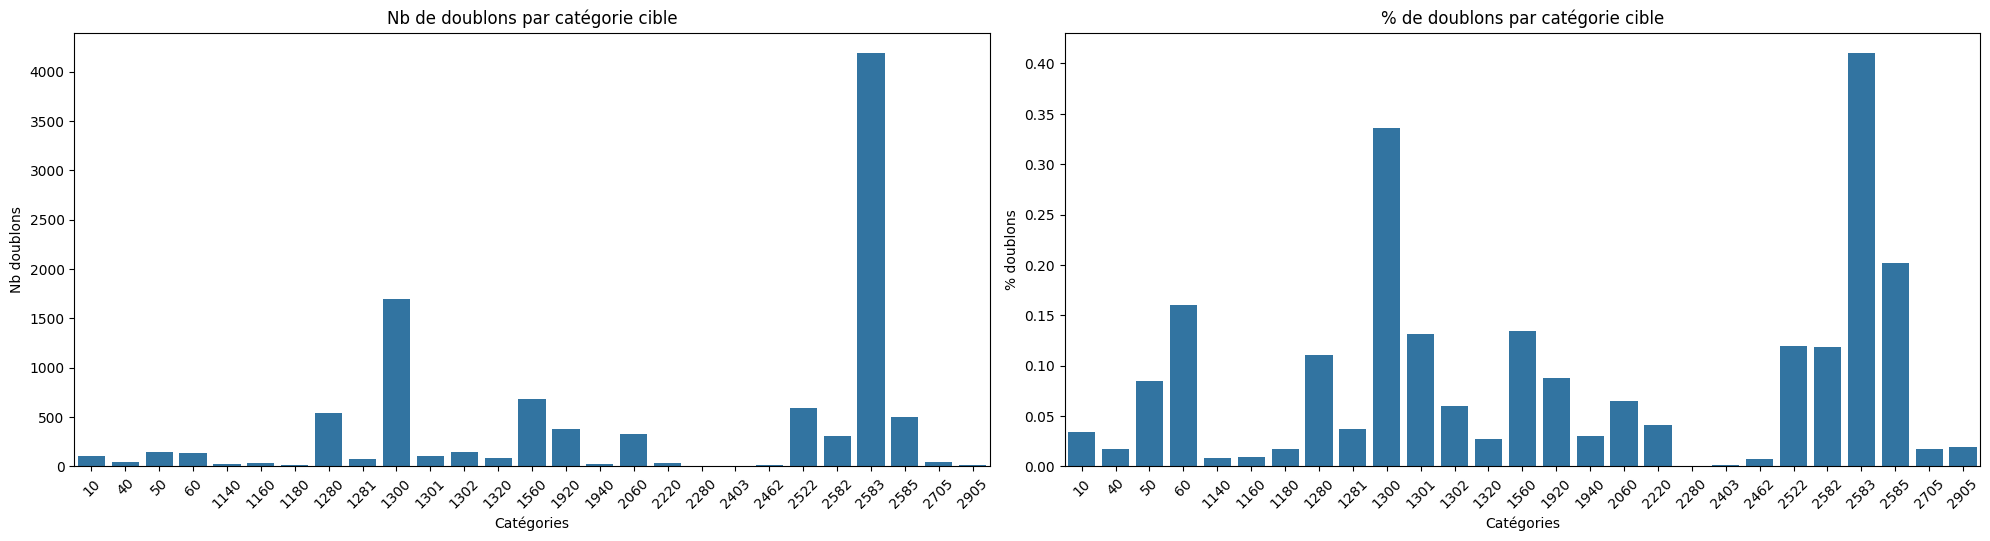

In [55]:
plt.figure(figsize=(20,10))
plt.subplot(221)

# Nombre de doublon d'image par catégorie cible
sns.barplot(y=duplicated, x=duplicated.index)
plt.title("Nb de doublons par catégorie cible")
plt.xlabel("Catégories")
plt.ylabel("Nb doublons")
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(222)

# Nombre de doublon d'image par catégorie cible
sns.barplot(y=duplicated_normalized, x=duplicated_normalized.index)
plt.title("% de doublons par catégorie cible")
plt.xlabel("Catégories")
plt.ylabel("% doublons")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

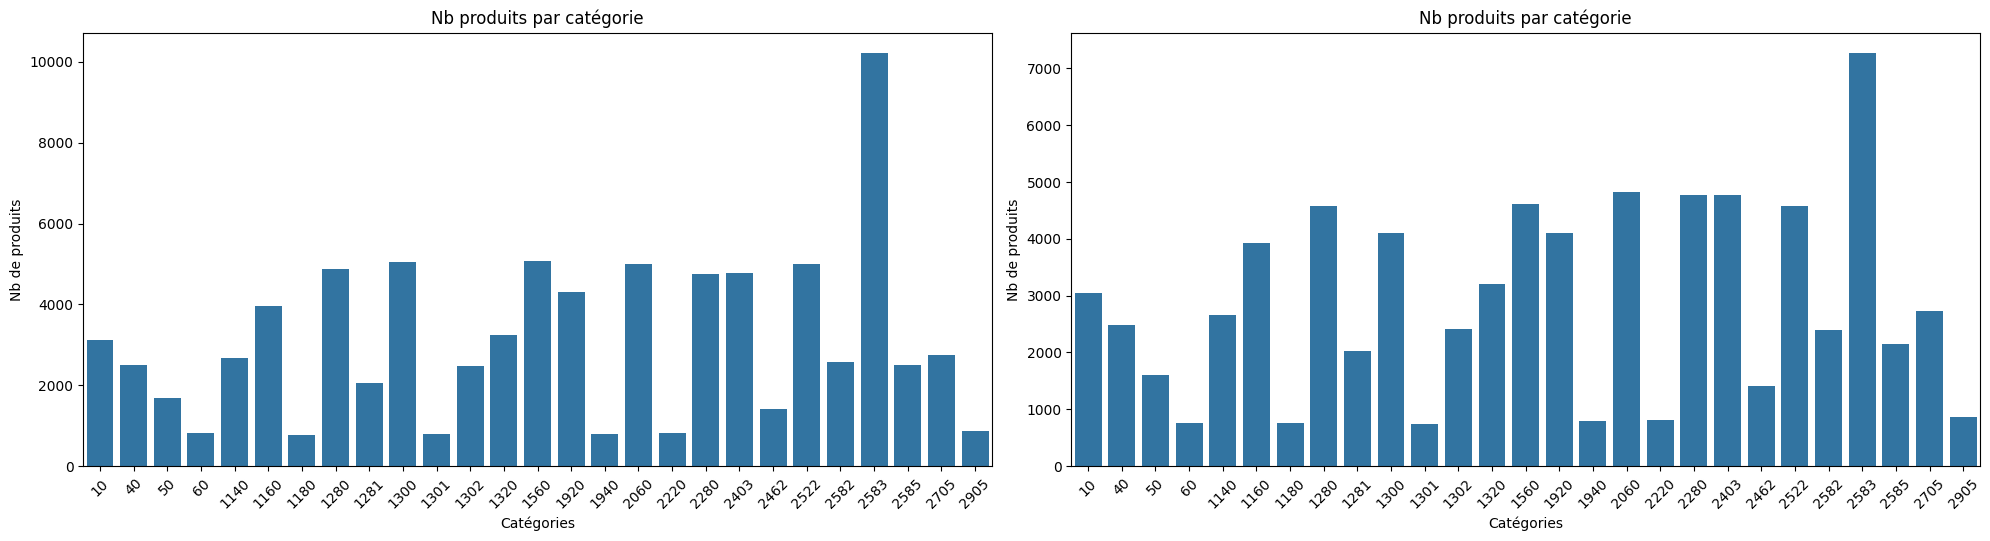

In [56]:
plt.figure(figsize=(20,10))
plt.subplot(221)


sns.countplot(x=train["prdtypecode"])
plt.title("Nb produits par catégorie")
plt.xlabel("Catégories")
plt.ylabel("Nb de produits")
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(222)


sns.countplot(x=train_wo_duplicates["prdtypecode"])
plt.title("Nb produits par catégorie")
plt.xlabel("Catégories")
plt.ylabel("Nb de produits")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Conclusion

- le dataset comporte environ 12% de doublons
- 2 catégories comportent un nombre d'important de doublons: les piscines (41%) et le modélisme (33%)
- la suppression pure est simple des doublons semble rééquilibré un peu la distribution de classes

## Divers

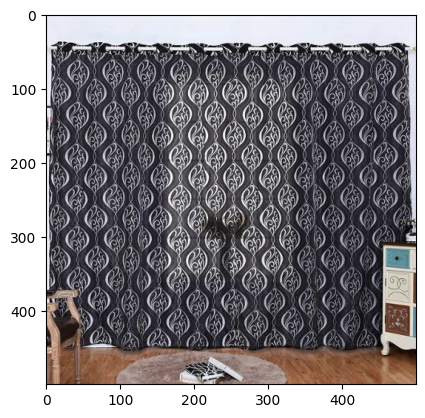

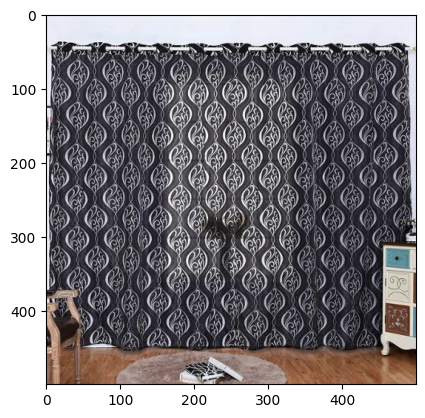

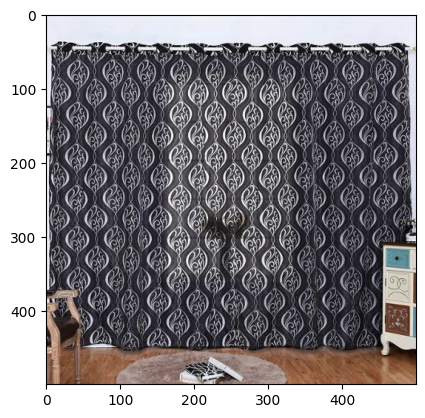

In [21]:
image_train_clean["filename"] = "image_" + image_train_clean["imageid"].astype(str) + "_product_" + image_train_clean["productid"].astype(str) + ".jpg"
temp_dir_path = "/mnt/c/Users/karim/rakuten/images/data_clean/image_train"
for index, row in img_clean[img_clean["hash"] == "ca95b1aad5aa81d5"].iterrows():
    filepath = os.path.join(temp_dir_path, row["filename"])
    image = plt.imread(filepath)  
    plt.imshow(image)
    #plt.axis("off")
    plt.show()